In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rec

import IDSP as idsp

from scipy.sparse import bsr_array
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

import scipy.constants as const

In [8]:
# extraction parameters
horizontal_span=100
vertical_span = 14

# the ICCD camera drift....
horizontal_shift = 50

# physics constants
Ar_line = 480.60202 #nm

# Read the data!!!
Here I made a new module named ```IDSP```.
Use the ```idsp.ICCD_image(date, shot_in_the_date)``` should give you the image.
So in the following process, all we need to do is to keep track of the ```date``` and ```shot_in_the_date``` variable,
and tuning the parameter for ```scipy.signal.find_peak``` to correctly find the dots

In [195]:
date = 240828
shot_in_the_date = 54

In [196]:
data = idsp.ICCD_image(date, shot_in_the_date)

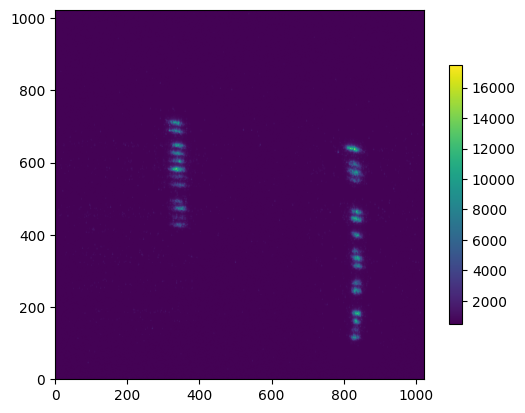

In [197]:
plt.imshow(data, origin='lower')
plt.colorbar(shrink=0.7)

## Next to correct the y position!!!
first extract the area where the dots locate, then bin them toward the left, and find the peaks.

In [198]:
IDSP_ch_file = pd.read_csv('./IDSP_ch.csv')

In [199]:
IDSP_col1 = IDSP_ch_file[IDSP_ch_file['band'] == 'green']
IDSP_col2 = IDSP_ch_file[IDSP_ch_file['band'] == 'red']

col1_mean = IDSP_col1['Ar_line[px]'].mean().astype(int) + horizontal_shift
col2_mean = IDSP_col2['Ar_line[px]'].mean().astype(int) + horizontal_shift

# why here comes the ```int(IDSP_col1.loc[0]['y2[px]']-50)``` something, is to search dots in as the smallest region
# as possible. If the region where we search the dots is too big, the noise may come in and is very annoying!!!!
col1_area = data[int(IDSP_col1.iloc[0]['y2[px]']-50):int(IDSP_col1.iloc[-1]['y2[px]']+50), 
                col1_mean-horizontal_span//2:col1_mean+horizontal_span//2]
col2_area = data[int(IDSP_col2.iloc[0]['y2[px]']-50):int(IDSP_col2.iloc[-1]['y2[px]']+50), 
                col2_mean-horizontal_span//2:col2_mean+horizontal_span//2]

In [200]:
bin1 = col1_area.sum(axis=1)
bin2 = col2_area.sum(axis=1)

In [201]:
peaks1, _ = find_peaks(bin1, height=1.e5, distance=15)
peaks2, _ = find_peaks(bin2, height=1.e5, distance=15)

In [202]:
# horizontal_shift = 90

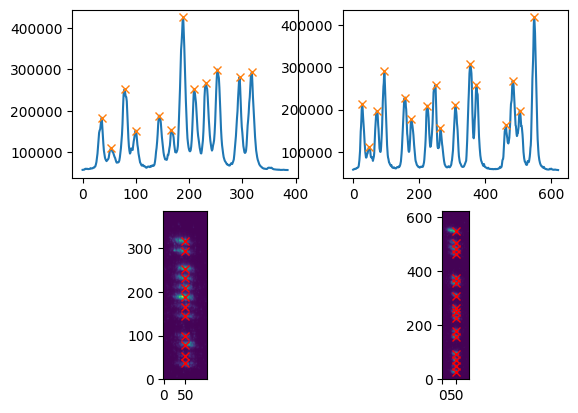

In [203]:
plt.figure()
plt.subplot(221)
plt.plot(bin1)
plt.plot(peaks1, bin1[peaks1], 'x')

plt.subplot(222)
plt.plot(bin2)
plt.plot(peaks2, bin2[peaks2], 'x')

plt.subplot(223)
plt.imshow(col1_area, origin='lower')
plt.plot(np.ones(12) * 50, peaks1, 'rx')

plt.subplot(224)
plt.imshow(col2_area, origin='lower')
plt.plot(np.ones(16) * 50, peaks2, 'rx')

# Save the data!!
First, save the calibration data, and then extract the dots and bin them, finally save them group by group, angle by angle, in a uniformed format.

In [204]:
y_new_green = peaks1 + int(IDSP_col1.iloc[0]['y2[px]']-50)
y_new_red = peaks2 + int(IDSP_col2.iloc[0]['y2[px]']-50)

In [205]:
IDSP_ch_file['y_new[px]'] = np.hstack([y_new_green, y_new_red])

In [206]:
try:
    IDSP_ch_file.to_csv('./%s/shot%s/IDSP_ch_new.csv' %(date, shot_in_the_date), index=False)
except OSError:
    try:
        os.mkdir('./%s/shot%s' %(date, shot_in_the_date))
    except FileNotFoundError:
        os.mkdir('./%s' %date)
        os.mkdir('./%s/shot%s' %(date, shot_in_the_date))
    IDSP_ch_file.to_csv('./%s/shot%s/IDSP_ch_new.csv' %(date, shot_in_the_date), index=False)

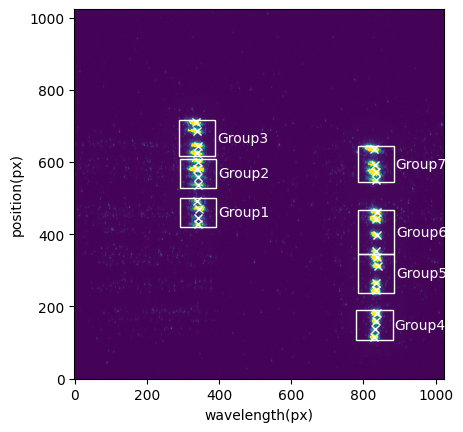

In [207]:
x, bins = np.histogram(data.ravel(), bins=256)
bins_center = ((bins[:-1] + bins[1:])/2)
idx_09 = np.abs((np.cumsum(x)/data.size - 0.995)).argmin() # get where the accumualted density is equal to 0.9
idx_01 = np.abs((np.cumsum(x)/data.size - 0.05)).argmin() # get where the accumualted density is equal to 0.1

plt.figure()
plt.imshow(data, origin='lower', clim=[bins_center[idx_01], bins_center[idx_09]])

plt.plot(IDSP_ch_file['Ar_line']+horizontal_shift, IDSP_ch_file['y_new[px]'], 'wx')


plt.xlabel('wavelength(px)')
plt.ylabel('position(px)')


group_names = np.unique(IDSP_ch_file['Group'])


for group_name in group_names:

    IDSP_group = IDSP_ch_file[IDSP_ch_file['Group']==group_name]
    
    height = np.abs(IDSP_group.iloc[0]['y_new[px]'] - IDSP_group.iloc[-1]['y_new[px]'])
    
    rect = rec((IDSP_group.iloc[0]['Ar_line[px]']-horizontal_span//2+horizontal_shift, 
                IDSP_group.iloc[0]['y_new[px]']-vertical_span//2), 
               width=horizontal_span, height=height+vertical_span, facecolor='none', edgecolor='w')
    
    plt.gca().add_patch(rect)

    plt.text(IDSP_group.iloc[0]['Ar_line[px]']+horizontal_span//2+5+horizontal_shift,
             IDSP_group.iloc[0]['y_new[px]']+height//2, 
             '%s' %group_name, c='w', verticalalignment='center')

plt.savefig('./%s/shot%s/data extraction corrected.png' %(date, shot_in_the_date), dpi=600)

## save the dots
now to extract the dots group by gourp, angle by angle, and store them to a unified format

In [208]:
group_names = np.unique(IDSP_ch_file['Group'])

In [209]:
df = pd.DataFrame()

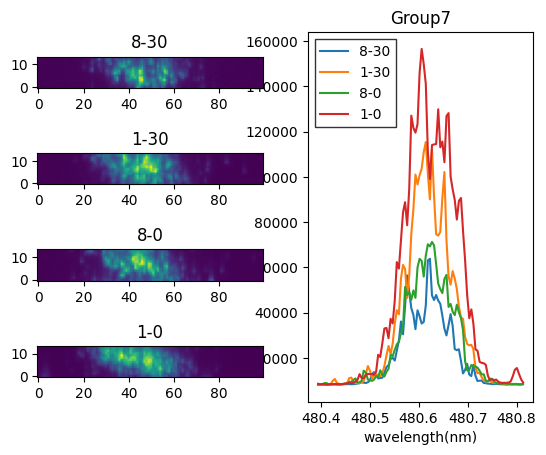

In [210]:
plt.close()

fig= plt.figure()

gs = fig.add_gridspec(4, 2)

ax5 = fig.add_subplot(gs[:, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])


for group_name in group_names:
    
    IDSP_ch_group = IDSP_ch_file[IDSP_ch_file['Group']==group_name]
    ax5.cla()
    ax5.set_xlabel('wavelength(nm)')

    for i, ax in enumerate([ax1, ax2, ax3, ax4]):
        
        ar_line1 = IDSP_ch_group.iloc[i]['Ar_line[px]'] + horizontal_shift
        y1 = IDSP_ch_group.iloc[i]['y_new[px]']
        ld1 = IDSP_ch_group.iloc[i]['linear dispersion']
        ch_name = IDSP_ch_group.iloc[i]['Probe number']
    
        
        dot1 = data[y1-vertical_span//2:y1+vertical_span//2, 
                    ar_line1-horizontal_span//2:ar_line1+horizontal_span//2]
    
        
        ax.imshow(dot1, origin='lower')
        ax.set_title(ch_name)

        wavelength = np.arange(-horizontal_span//2, horizontal_span//2) * -ld1 + Ar_line
        intensity = dot1.sum(axis=0)
        ax5.plot(wavelength, intensity, label=ch_name)
    
        try:
            
            df['wavelength'] = wavelength
            df['intensity'] = intensity
            df.to_csv('./%s/shot%s/formatted_data/%s_%s.csv' 
                      %(date, shot_in_the_date, group_name, ch_name), index=False)
        except OSError:
            
            os.mkdir('./%s/shot%s/formatted_data' %(date, shot_in_the_date))
            df.to_csv('./%s/shot%s/formatted_data/%s_%s.csv' 
                      %(date, shot_in_the_date, group_name, ch_name), index=False)
    
    
    ax5.set_title(group_name)
    ax5.legend(fancybox=False, edgecolor='k')

    fig.savefig('./%s/shot%s/formatted_data/%s.jpg' %(date, shot_in_the_date, group_name), dpi=600)